In [1]:
import itk
import matplotlib.pyplot as plt
import numpy as np

In [2]:
layer = 80

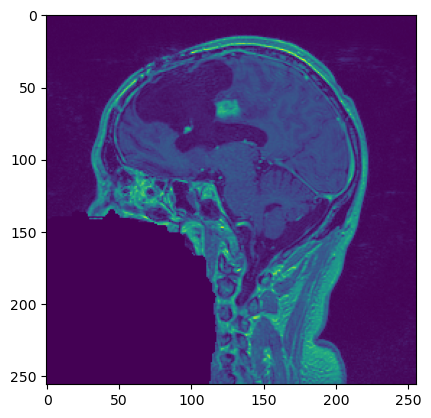

In [3]:
image = itk.imread("Data/case6_gre1.nrrd", itk.D)
plt.imshow(image[layer])

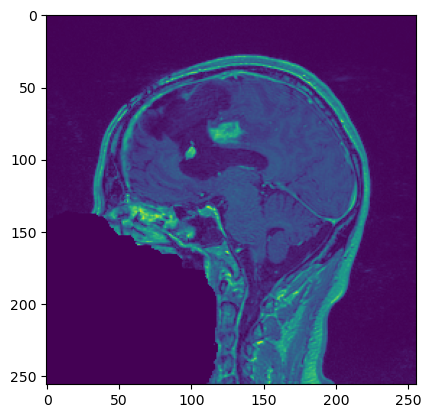

In [4]:
image2 = itk.imread("Data/case6_gre2.nrrd", itk.D)
plt.imshow(image2[layer])

In [26]:
def Recalage(fixed, moving):

    fixed_image = itk.imread(fixed, itk.F)
    moving_image = itk.imread(moving, itk.F)

    type_ = type(fixed_image)
    outType_ = itk.Image[itk.F, 3]
    
    registration_method = itk.ImageRegistrationMethodv4[type_, type_].New()
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)
    
    transform_type = itk.TranslationTransform[itk.D, 3].New()
    transform_type.SetIdentity()
    registration_method.SetInitialTransform(transform_type)

    metric = itk.MeanSquaresImageToImageMetricv4[type_, type_].New()
    metric.SetFixedImage(fixed_image)
    metric.SetMovingImage(moving_image)

    registration_method.SetMetric(metric)

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
    optimizer.SetLearningRate(4.0)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(5)
    registration_method.SetOptimizer(optimizer)
    
    registration_method.Update()
    final_transform = registration_method.GetTransform()
    
    resampler = itk.ResampleImageFilter[type_, type_].New()
    resampler.SetInput(moving_image)
    resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampler.SetOutputOrigin(fixed_image.GetOrigin())
    resampler.SetOutputSpacing(fixed_image.GetSpacing())
    resampler.SetOutputDirection(fixed_image.GetDirection())
    resampler.SetTransform(final_transform)

    resampler.Update()
    resampled_image = resampler.GetOutput()

    cast_filter = itk.CastImageFilter[type_, outType_].New()
    cast_filter.SetInput(resampled_image)
    cast_filter.Update()
    return cast_filter.GetOutput()

In [27]:
recalee = Recalage("Data/case6_gre1.nrrd", "Data/case6_gre2.nrrd")

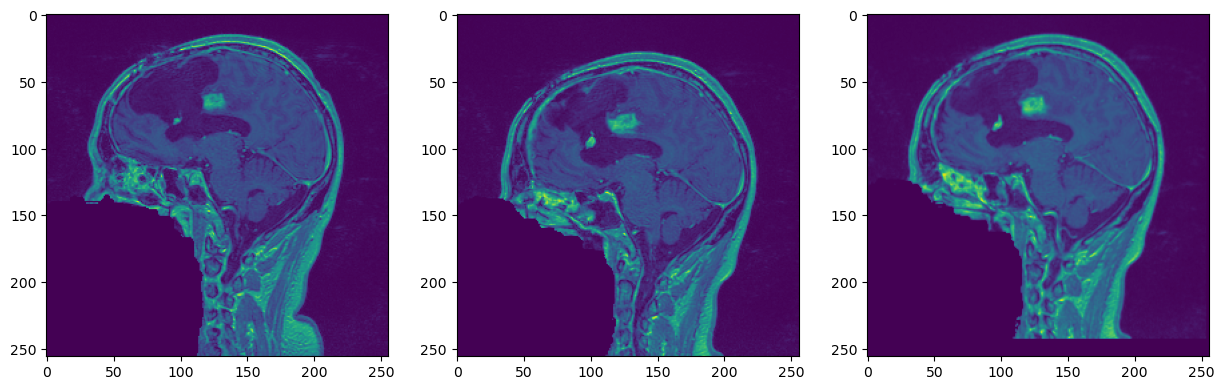

In [30]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(image[layer])
plt.subplot(1,3,2)
plt.imshow(image2[layer])
plt.subplot(1,3,3)
plt.imshow(recalee[layer])

In [8]:
import vtk

# Load the NRRD file
reader = vtk.vtkNrrdReader()
reader.SetFileName("Data/case6_gre1.nrrd")
reader.Update()

# Create a mapper
mapper = vtk.vtkSmartVolumeMapper()
mapper.SetInputConnection(reader.GetOutputPort())

# Create an opacity transfer function
opacity_tf = vtk.vtkPiecewiseFunction()
opacity_tf.AddPoint(255, 1.0)
opacity_tf.AddPoint(0, 0.0)

# Create a color transfer function
color_tf = vtk.vtkColorTransferFunction()
color_tf.AddRGBPoint(255, 1.0, 1.0, 1.0)
color_tf.AddRGBPoint(0, 0.0, 0.0, 0.0)

# Create a volume property
volume_property = vtk.vtkVolumeProperty()
volume_property.SetScalarOpacity(opacity_tf)
volume_property.SetColor(color_tf)

# Create a volume
volume = vtk.vtkVolume()
volume.SetMapper(mapper)
volume.SetProperty(volume_property)

# Create a renderer
renderer = vtk.vtkRenderer()
renderer.AddVolume(volume)
renderer.SetBackground(0, 0, 0)

# Create a render window
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

# Create an interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Start the interaction
interactor.Initialize()
interactor.Start()
